In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


# Weight Initialization
> All you need is a good init

In [2]:
#export

from exp.nb_01 import *

import gzip
import pickle
import torch
import math

from fastai import datasets
from torch import tensor
from torch.nn import init

import torch.nn as nn
import matplotlib.pyplot as plt

## Data

Create a few helper functions to download the data and then normalize it.

In [3]:
#export
def get_data():
    path = datasets.download_data('http://deeplearning.net/data/mnist/mnist.pkl', ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x,m,s): return (x-m)/s

Now grab the data and convert into tensors

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

### Normalizing Data

To normalize our training and validation sets we use the statistics from the training set. This is important to note. 

The model is going to 'learn' from the training data. Whatever the models sees during this learning phase is what becomes its normal or base line. 

The validation set could contain outliers or examples that are not in the training set. And since by definition it is smaller than the training set, these outliers might skew validation set if it was normalized using its own mean and std. 

Then when the model went to predict the validation set, and give us a sense of how it is generalizing, it would be systematically wrong.

In [5]:
train_mean, train_std = x_train.mean(), x_train.std(); train_mean, train_std

(tensor(0.1304), tensor(0.3073))

Before normalizing the mean is around .13 and the std is .3

In [6]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

After normalizing our training mean is nearly zero and the standard deviation is close to 1.

In [7]:
#export
def get_stats(a): return f"Mean: {a.mean()}  STD: {a.std()}"

In [8]:
get_stats(x_train)

'Mean: -6.259815563680604e-06  STD: 1.0'

Here is a simple test of whether a tensor is near zero using `assert`: if its true do nothing else throw error and return error message.

In [9]:
#export
def test_near_zero(a, tol=1e-02): assert a.abs()<tol, f"Near zero: {a}"

In [10]:
test_near_zero(x_train.mean())
test_near_zero(1-x_train.std())

In [11]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

Each layer of our network will be composed of a linear operation followed by a non-linear function. 

One layer feeds into the next. A matrix of inputs is multiplied by a matrix of weights which is then put through a non-linearity and that's essentially what our basic network's "forward pass" will consist of. 

Here is the linear operation:

In [12]:
#export
def lin(x, w, b):
    return x@w + b

## The Importance of Good Weights

After loading the data and defining our linear function we just need some weights or parameters. 

As a start we will randomly initialize the weights and biases and see where that leads us. 

We'll use `torch.randn()`:

    Returns a tensor filled with random numbers from a normal distribution
    with mean `0` and variance `1` (also called the standard normal
    distribution).

In [13]:
nh = 50 # number of hidden units

w1 = torch.randn(m,nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)
b2 = torch.zeros(1)

Our mean is close to 0 and our std is near 1 - just like our data above.

In [14]:
get_stats(w1)

'Mean: -0.0009383115684613585  STD: 1.0036629438400269'

In [15]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1)

In [16]:
out1 = lin(x_valid, w1, b1)

In [17]:
get_stats(out1)

'Mean: -2.466474771499634  STD: 29.236644744873047'

After a single linear transformation the STD blows up and that is just after one step - we'll be doing thousands in a normal epoch. 

Why is this happening? What is the problem? And how do we fix it?

Let's explore what happens when we randomly initialize a matrix of inputs and then repeatedly multiple that matrix by a set of weights.

In [18]:
x1 = torch.randn(512)
w1 = torch.randn(512, 512)

In [19]:
for i in range(100): x1 = w1 @ x1

In [20]:
get_stats(x1)

'Mean: nan  STD: nan'

This is called an "activation explosion" - after a certain number of operations the activations become NaN.

Let's look closer...

In [21]:
x2 = torch.randn(512)
w2 = torch.randn(512, 512)

for i in range(100): 
    x2 = w2 @ x2
    if i % 10 == 0: print(x2.std())
    if x2.std() != x2.std(): break

i

tensor(23.1943)
tensor(8.3898e+14)
tensor(3.1616e+28)


27

After 28 iterations the std of blows up and we effectively get an overflow error. 

We can also go the other way and get an underflow error if our weights are scaled too small. Then our activations vanish by becoming arbitrarily close to zero. 

In [22]:
x3 = torch.randn(512)
w3 = torch.randn(512,512) * 0.01

for i in range(100): x3 = w3 @ x3

In [23]:
get_stats(x3)

'Mean: 0.0  STD: 0.0'

What is needed is a method to initialize the weights in relation to the inputs so that our activations do not explode or vanish but stay within a range where we can effectively find the gradient and make our backward pass.

In [24]:
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [25]:
test_near_zero(w1.mean())
test_near_zero(w1.std()-1/math.sqrt(m))

In [26]:
get_stats(w1)

'Mean: -3.3752876333892345e-05  STD: 0.035833973437547684'

In [27]:
out = lin(x_valid, w1, b1)

In [28]:
get_stats(out)

'Mean: -0.0979047417640686  STD: 0.9452735781669617'

## Weight Initialization Techniques

### Xavier

We want to prevent activations from each layer from exploding or vanishing during the forward pass. If either occurs, loss gradients will either be too large or too small to flow backwards and effectively adjust the weights, 
which may prevent the network from learning anything. 

Another way of saying this is that we want the variance to remain the same as the input passes through the layers

Xavier initialization was proposed in the paper <a href="http://proceedings.mlr.press/v9/glorot10a.html"> "Understanding the difficulty of training deep feedforward neural networks"</a>

Essentially it scales the weights by dividing them by a "special" number. 

In [29]:
x4 = torch.randn(512)
w4 = torch.randn(512,512) / math.sqrt(512)

get_stats(x4)

'Mean: 0.008204437792301178  STD: 0.9810438752174377'

In [30]:
for i in range(100): x4 = w4 @ x4
    
get_stats(x4)

'Mean: -0.6096658706665039  STD: 7.058265686035156'

Often it works - the mean is near 0 and the STD is near 1. There is some variablity due to the fact that we are randomly generating the weights.

Now let's focus on the divisor. Its simply a small scalar. But where did 512 come from? And why take the square root?

In [31]:
1  / math.sqrt(512)

0.044194173824159216

By definition our `torch.randn()` outputs a tensor from a standard normal distribution (mean `0` and variance `1`).

When the mean is 0 the standard deviation ends up being just the square root of the mean of `x` squared.
<p>
$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]} = \sqrt{ \frac{ \left[(x_{0})^{2} + (x_{1})^{2} + \cdots + (x_{n-1})^{2} \right] }{n} }$$
</p>

In [32]:
mean,sqr = 0.,0.
b=1000

for i in range(b):
    x = torch.randn(512)
    a = torch.randn(512, 512)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/b,sqr/b

(-0.017069486536085605, 511.4135527038574)

If we run this experiment a 1000 times we see that the STD converges to 512 and the mean stays around 0. 


In [33]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(0.00026813922856545105, 0.9474822903664666)

Then we sum 512 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 512, hence `math.sqrt(512)` being our magic number. If we scale the weights of the matrix `a` and divide them by this `math.sqrt(512)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

### Adding a non-linearity

Now we need a non-linear activation function otherwise we would be very limited in what types of functions the network could learn. 

We'll use a Rectified Linear Unit (ReLU).

In [34]:
def relu(x): return x.clamp_min(0.)

The full first layer is not a linear transformation followed by a relu:

In [35]:
out = relu(lin(x_valid, w1, b1))

In [36]:
get_stats(out)

'Mean: 0.3253205716609955  STD: 0.5088699460029602'

After applying the relu the mean has grown to nearly `.5` 

Let's take a closer look at what happens here.

First, let's look at the how the weights are distributed:

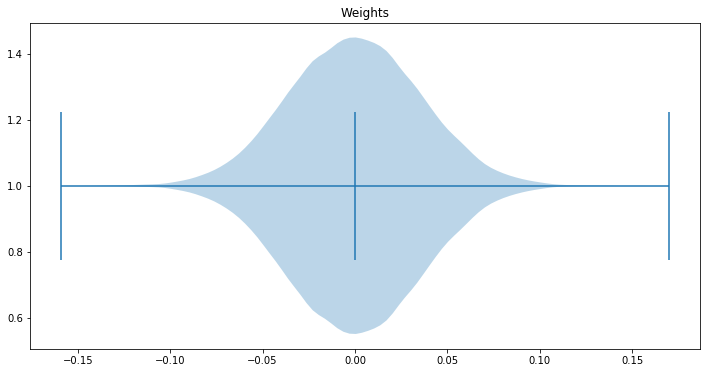

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Weights')
# ax2.set_ylabel()
ax.violinplot(w1.view(-1), points=100, vert=False, widths=0.9,
                      showmeans=True, showextrema=True)

plt.show()

In [38]:
get_stats(x_train)

'Mean: -6.259815563680604e-06  STD: 1.0'

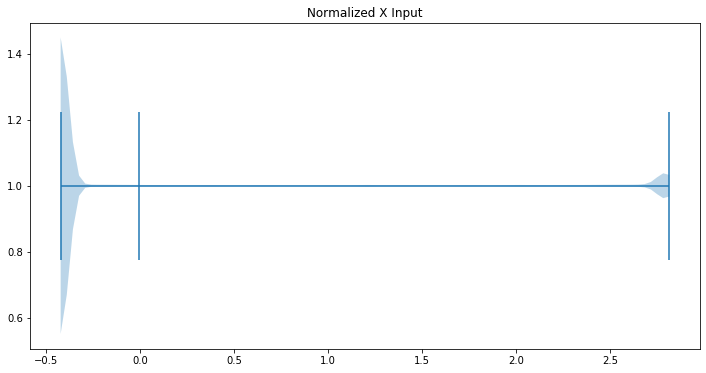

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Normalized X Input')
# ax2.set_ylabel()
ax.violinplot(x_valid.view(-1), points=100, vert=False, widths=0.9,
                      showmeans=True, showextrema=True)

plt.show()

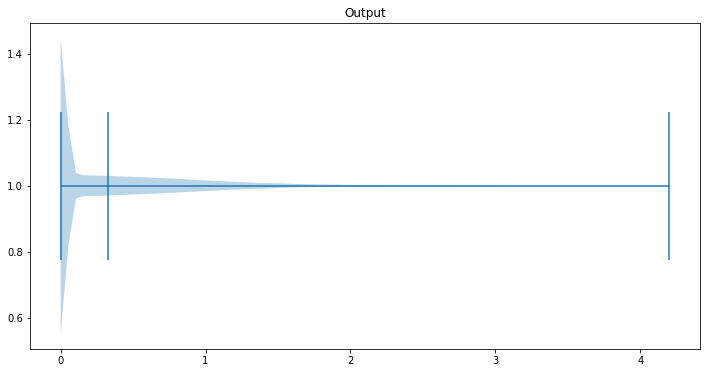

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title('Output')
# ax2.set_ylabel()
ax.violinplot(out.view(-1), points=80, vert=False, widths=0.9, showmeans=True, showextrema=True)

plt.show()

Text(0.5, 1.0, 'Normalized X Inputs')

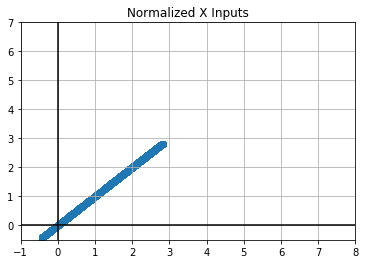

In [41]:
plt.scatter(x_valid.view(-1), x_valid.view(-1))
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlim(-1, 8)
plt.ylim(-.5, 7)
plt.title("Normalized X Inputs")

Text(0.5, 1.0, 'Activations after Relu')

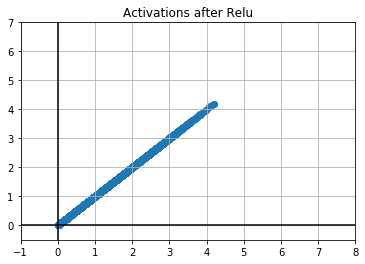

In [42]:
plt.scatter(out, out)
plt.grid()
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlim(-1, 8)
plt.ylim(-.5, 7)
plt.title("Activations after Relu")

Let's run some experiments here to find out what is going on with our activations after the relu

In [43]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    y = 0 if y < 0 else y.item() # this is relu
    mean += y
    sqr  += y ** 2
mean/10000,sqr/10000


(0.3171522337410329, 0.5059323622760529)

The mean shifts up and the STD gets cut in half. This is simply the result of turning all the negative numbers into zeros. 

If we do the same experiment with the whole matrices we can the same thing happens.

In [44]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(512)
    a = torch.randn(512, 512)
    y = a @ x
    y = y.clamp(min=0)
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(8.89510202407837, 250.1297917175293)

### Kaiming

In order to counteract the effects of the relu we need a slighty different divisor - a new type of initialization.

We'll use the __Kaiming initialization__ which was first presented in <a href='https://arxiv.org/abs/1502.01852'>Delving Deep into Rectifiers </a>

<p>
$$\text{std} = \sqrt{\frac{2}{(1 + a^2) \times \text{fan_in}}}$$
</p>

In [45]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)
get_stats(w1)

'Mean: -0.00034683154080994427  STD: 0.05060731619596481'

We can see this effectively reduces our STD. 

Uses these weights in our first layer we get a slightly high mean but a STD closer to 1 which is what want. 

In [46]:
out = relu(lin(x_valid, w1, b1))
get_stats(out)

'Mean: 0.49218422174453735  STD: 0.7651132941246033'

Now let's run a short experiment to see how this holds up over many iterations.

In [47]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(512)
    a = torch.randn(512, 512) * math.sqrt(2/512)
    y = a @ x
    y = y.clamp(min=0) - .5
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.05804177032085136, 0.6777637606859207)

One small trick is to subtract .5 from the relu. 

## Pytorch init

Now that we have implemented Xavier and Kaiming (He) initialization methods from scratch we can use the Pytorch implementations.

    Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    normal distribution.
   


In [48]:
w1 = torch.zeros(m, nh)
init.kaiming_normal_(w1, mode="fan_out")
out = relu(lin(x_valid, w1, b1))

In [49]:
get_stats(w1)

'Mean: 0.00025265206932090223  STD: 0.05046749860048294'

In [50]:
get_stats(out)

'Mean: 0.5450865030288696  STD: 0.8341204524040222'

In [51]:
!python notebook2script.py 01a_weight_init.ipynb

Converted 01a_weight_init.ipynb to exp\nb_01a.py
